# ECE 523 Final Project: KNN Classifier 

In [1]:
#Imports______________________________________________________________
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import accuracy_score
from keras.datasets import cifar10
from tqdm import tqdm #for progress bars
import matplotlib
matplotlib.rcParams.update({'text.usetex': True, 
                            'font.family': 'Computer Modern Roman'})
import warnings
warnings.filterwarnings('ignore')

2024-05-05 13:56:19.275653: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-05 13:56:19.281424: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-05 13:56:20.599156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Load in data, Normalize and format
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

#Normalize and format
train_images = train_images / 255 
test_images  = test_images / 255

#Check data dimensions
print(train_images.shape)
print(train_labels.shape) 

(50000, 32, 32, 3)
(50000, 1)


In [3]:
#Reshape data: flatten individual 32x32x3 vectors to 1d vectors of length 32*32*3=3072  
train_img = np.reshape(train_images, (train_images.shape[0], -1)).astype("float")
test_img = np.reshape(test_images, (test_images.shape[0], -1)).astype("float")
print(test_img.shape)

(10000, 3072)


In [5]:
#Define the K Nearest Neighbor classifer:
class KNN(object):
    def __init__(self):
        pass
    def fit(self, x, y):
        """
        Load in training data. 
        ______________________
        x: training data
        y: training labels
        """
        self.traindata = x
        self.trainlabels = y
    
    def distances(self, x):
        """ 
        Compute Euclidean distances between training and test data 
        in feature space. 
        Makes use of broadcasting for efficiency, motivated by 
        https://ryli.design/blog/knn
        and 
        https://cs231n.github.io/classification/.
        ___________________________________________________________
        x: test data

        returns: d, euclidean distances between each training and 
                 test vector ( shape ( x.shape[0], self.traindata.shape[0] ) )
        """
        d = np.sqrt(np.sum(np.square(self.traindata), axis=1) +
                    np.sum(np.square(x), axis=1)[:, np.newaxis] -
                    2 * np.dot(x, self.traindata.T))
        return d
    
    def predict(self, dists, k=5):
        """ 
        Predict labels of input testing data. 
        _____________________________________
        dists: Euclidean distances between 
               test and train data. 
        k:     Integer number of nearest neighbors
               to consider for label prediction. 

        returns: label predictions for test data. 
        """
        nearest_labels=[]
        print('Predicting labels...')
        for i in tqdm(range(dists.shape[0])):

            #sort and collect nearest K distances
            cd = np.argsort(dists[i])[0:k] 

            #select most common labels from K Nearest neighbors
            nearest_label = self.trainlabels[ cd ]
            nearest_labels.append(np.argmax(np.bincount(nearest_label[:, 0])))
        
        nearest_labels=np.array(nearest_labels)
        return nearest_labels
    
    def evaluate(self, x, y, k=5):
        """ 
        Evaluate accuracy of classification for a value of k. 
        _____________________________________________________
        x: test data
        y: test labels
        k: Integer number of nearest neighbors to consider for
           label prediction. 
        """
        dists = self.distances(x)
        preds = self.predict(dists, k=k)
        score = accuracy_score(y, preds)

        n_corr = np.sum(preds == y)
        n_tot  = x.shape[0]
        print('Accuracy: {:.3f}%'.format(100*score))
        return score, n_corr, n_tot

In [12]:
clf = KNN()
clf.fit(train_img, train_labels)
clf.evaluate(test_img, test_labels, k=7)

Predicting labels...


100%|██████████| 10000/10000 [00:41<00:00, 238.18it/s]


Accuracy: 33.580%


(0.3358, 10000000, 10000)

In [44]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(accuracy_score(test_labels, preds))
print(classification_report(test_labels, preds))
print(confusion_matrix(test_labels, preds))

0.1027
              precision    recall  f1-score   support

           0       0.09      0.12      0.10      1000
           1       0.07      0.02      0.03      1000
           2       0.11      0.18      0.13      1000
           3       0.10      0.08      0.09      1000
           4       0.11      0.21      0.14      1000
           5       0.10      0.07      0.08      1000
           6       0.10      0.12      0.11      1000
           7       0.10      0.04      0.06      1000
           8       0.12      0.18      0.14      1000
           9       0.06      0.01      0.02      1000

    accuracy                           0.10     10000
   macro avg       0.10      0.10      0.09     10000
weighted avg       0.10      0.10      0.09     10000

[[117  25 157  70 203  62 121  56 160  29]
 [131  19 173  91 183  72  92  44 162  33]
 [118  31 181  68 218  69 108  38 147  22]
 [112  37 182  77 202  68 110  34 151  27]
 [120  18 163  55 209  86 129  39 143  38]
 [127  21 171  65 1

Predicting labels...


100%|██████████| 10000/10000 [00:41<00:00, 238.52it/s]


0.3358


Text(0.5, 1.0, 'KNN Confusion')

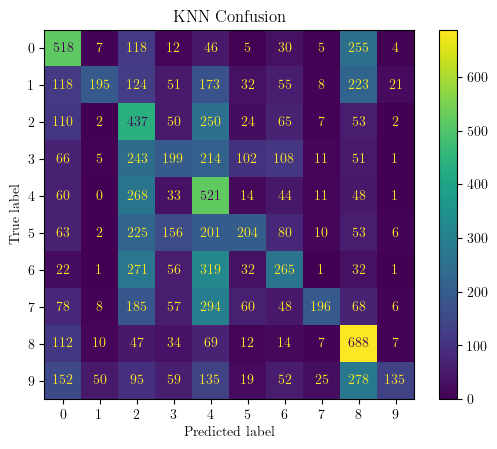

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix 

clf = KNN()
clf.fit(train_img, train_labels)
ds = clf.distances(test_img)
preds = clf.predict(ds, k=7)
print(accuracy_score(test_labels, preds))
cm = confusion_matrix(test_labels, preds)

CM = ConfusionMatrixDisplay(cm)
CM.plot()
plt.title('KNN Confusion')

In [42]:
#Classify test images, for a number of choices for K
choices = [i+1 for i in range(20)]
dists = clf.distances(test_img)
scores = []
for k in tqdm(choices):
    label_pred = clf.predict(dists, k=k) 
    acc=accuracy_score(label_pred, test_labels)
    scores.append(acc)
    print('Accuracy for k={}: {}%'.format(k, acc*100))

  0%|          | 0/20 [00:00<?, ?it/s]

Predicting labels...


  5%|▌         | 1/20 [00:42<13:28, 42.55s/it]

Accuracy for k=1: 35.39%
Predicting labels...


 10%|█         | 2/20 [01:24<12:43, 42.39s/it]

Accuracy for k=2: 31.16%
Predicting labels...


 15%|█▌        | 3/20 [02:07<11:59, 42.33s/it]

Accuracy for k=3: 33.03%
Predicting labels...


 20%|██        | 4/20 [02:49<11:16, 42.29s/it]

Accuracy for k=4: 33.98%
Predicting labels...


 25%|██▌       | 5/20 [03:31<10:34, 42.29s/it]

Accuracy for k=5: 33.98%
Predicting labels...


 30%|███       | 6/20 [04:13<09:51, 42.27s/it]

Accuracy for k=6: 34.0%
Predicting labels...


 35%|███▌      | 7/20 [04:56<09:09, 42.27s/it]

Accuracy for k=7: 33.58%
Predicting labels...


 40%|████      | 8/20 [05:38<08:27, 42.26s/it]

Accuracy for k=8: 34.150000000000006%
Predicting labels...


 45%|████▌     | 9/20 [06:20<07:44, 42.26s/it]

Accuracy for k=9: 33.98%
Predicting labels...


 50%|█████     | 10/20 [07:02<07:02, 42.24s/it]

Accuracy for k=10: 33.86%
Predicting labels...


 55%|█████▌    | 11/20 [07:45<06:20, 42.24s/it]

Accuracy for k=11: 34.14%
Predicting labels...


 60%|██████    | 12/20 [08:27<05:38, 42.26s/it]

Accuracy for k=12: 34.29%
Predicting labels...


 65%|██████▌   | 13/20 [09:09<04:55, 42.23s/it]

Accuracy for k=13: 34.17%
Predicting labels...


 70%|███████   | 14/20 [09:51<04:13, 42.31s/it]

Accuracy for k=14: 34.07%
Predicting labels...


 75%|███████▌  | 15/20 [10:34<03:31, 42.38s/it]

Accuracy for k=15: 34.050000000000004%
Predicting labels...


 80%|████████  | 16/20 [11:16<02:49, 42.39s/it]

Accuracy for k=16: 34.02%
Predicting labels...


 85%|████████▌ | 17/20 [11:59<02:07, 42.46s/it]

Accuracy for k=17: 34.1%
Predicting labels...


 90%|█████████ | 18/20 [12:42<01:25, 42.54s/it]

Accuracy for k=18: 33.900000000000006%
Predicting labels...


 95%|█████████▌| 19/20 [13:25<00:42, 42.59s/it]

Accuracy for k=19: 33.98%
Predicting labels...


100%|██████████| 20/20 [14:07<00:00, 42.37s/it]

Accuracy for k=20: 33.75%


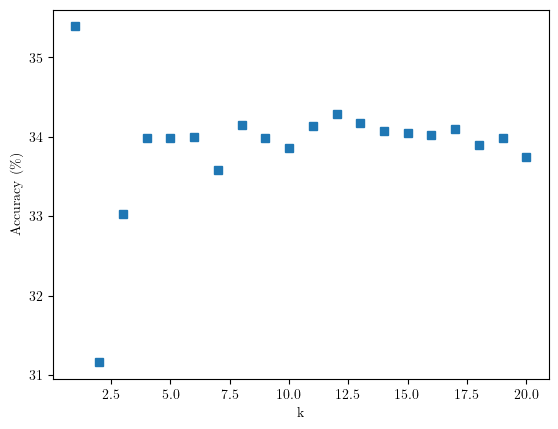

In [83]:
#Plot k vs. accuracy:
plt.plot(choices, 100*np.array(scores), 's')
plt.xlabel('k')
plt.ylabel('Accuracy (\%)')
plt.show()

In [78]:
n_splits = 5
ks = np.floor(np.logspace(np.log10(1.5), np.log10(25), 7+1)).astype(int) 

trn_img_split = []
trn_labels_split = []

trn_img_split = np.array_split(train_img, n_splits)
trn_labels_split = np.array_split(train_labels, n_splits)

k_acc_pairs = {} 

for k in tqdm(ks):
    k_acc_pairs[k] = []
    for split in range(n_splits):
        tst_img = trn_img_split[split]
        tst_lbl = trn_labels_split[split]
        trn_img = trn_img_split
        trn_labels = trn_labels_split
        
        trn_img = np.delete(trn_img,split,0)
        trn_img = np.concatenate((trn_img),axis = 0)
        trn_labels = np.delete(trn_labels,split,0)
        trn_labels = np.concatenate((trn_labels),axis = 0)
        
        clf = KNN()
        clf.fit(trn_img, trn_labels)
        dists = clf.distances(tst_img)
        pred = clf.predict(dists, k)

        accuracy = accuracy_score(tst_lbl, pred)

        print('Accuracy: ', 100*accuracy)

        k_acc_pairs[k].append(accuracy)

  0%|          | 0/8 [00:00<?, ?it/s]

Predicting labels...


100%|██████████| 10000/10000 [00:33<00:00, 302.90it/s]


Accuracy:  33.58
Predicting labels...


100%|██████████| 10000/10000 [00:33<00:00, 302.07it/s]


Accuracy:  33.61
Predicting labels...


100%|██████████| 10000/10000 [00:33<00:00, 302.94it/s]


Accuracy:  34.69
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 303.43it/s]


Accuracy:  33.46
Predicting labels...


 12%|█▎        | 1/8 [12:23<1:26:43, 743.32s/it]

Accuracy:  33.83
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 303.41it/s]


Accuracy:  30.680000000000003
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 305.04it/s]


Accuracy:  30.320000000000004
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 304.16it/s]


Accuracy:  30.819999999999997
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 304.16it/s]


Accuracy:  29.959999999999997
Predicting labels...


 25%|██▌       | 2/8 [24:47<1:14:21, 743.55s/it]

Accuracy:  30.04
Predicting labels...


100%|██████████| 10000/10000 [00:33<00:00, 302.98it/s]


Accuracy:  32.6
Predicting labels...


100%|██████████| 10000/10000 [00:33<00:00, 302.73it/s]


Accuracy:  32.61
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 303.44it/s]


Accuracy:  32.800000000000004
Predicting labels...


100%|██████████| 10000/10000 [00:33<00:00, 302.57it/s]


Accuracy:  32.519999999999996
Predicting labels...


 38%|███▊      | 3/8 [37:10<1:01:58, 743.69s/it]

Accuracy:  31.78
Predicting labels...


100%|██████████| 10000/10000 [00:33<00:00, 302.27it/s]


Accuracy:  33.5
Predicting labels...


100%|██████████| 10000/10000 [00:33<00:00, 302.31it/s]


Accuracy:  32.97
Predicting labels...


100%|██████████| 10000/10000 [00:33<00:00, 298.43it/s]


Accuracy:  33.36
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 303.18it/s]


Accuracy:  33.4
Predicting labels...


 50%|█████     | 4/8 [49:36<49:38, 744.64s/it]  

Accuracy:  32.83
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 304.18it/s]


Accuracy:  34.0
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 304.81it/s]


Accuracy:  33.300000000000004
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 304.00it/s]


Accuracy:  33.56
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 303.89it/s]


Accuracy:  33.1
Predicting labels...


 62%|██████▎   | 5/8 [1:02:01<37:13, 744.62s/it]

Accuracy:  32.37
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 304.09it/s]


Accuracy:  33.81
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 305.37it/s]


Accuracy:  32.43
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 304.56it/s]


Accuracy:  33.07
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 304.11it/s]


Accuracy:  33.07
Predicting labels...


 75%|███████▌  | 6/8 [1:14:26<24:49, 744.63s/it]

Accuracy:  32.32
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 304.30it/s]


Accuracy:  33.489999999999995
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 304.99it/s]


Accuracy:  32.49
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 303.61it/s]


Accuracy:  32.66
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 303.54it/s]


Accuracy:  32.83
Predicting labels...


 88%|████████▊ | 7/8 [1:26:57<12:26, 746.85s/it]

Accuracy:  31.990000000000002
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 304.31it/s]


Accuracy:  32.46
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 304.85it/s]


Accuracy:  31.78
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 304.00it/s]


Accuracy:  32.39
Predicting labels...


100%|██████████| 10000/10000 [00:32<00:00, 303.78it/s]


Accuracy:  32.22
Predicting labels...


100%|██████████| 8/8 [1:39:29<00:00, 746.20s/it]

Accuracy:  31.3


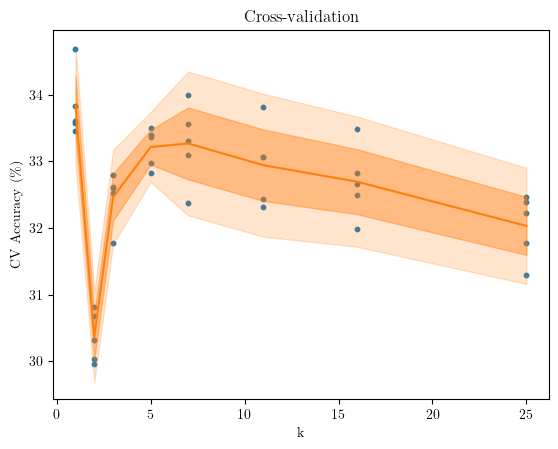

In [101]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for k in ks:
    accuracies = np.array(k_acc_pairs[k])
    plt.scatter([k] * len(accuracies), 100*accuracies, color=cycle[0], marker='o', s=10)

ac_mean = np.array([np.mean(v) for k,v in sorted(k_acc_pairs.items())])
ac_std = np.array([np.std(v) for k,v in sorted(k_acc_pairs.items())])
plt.plot(ks, 100*ac_mean, color=cycle[1])
plt.fill_between(ks, 100*(ac_mean-ac_std), 100*(ac_mean+ac_std), alpha=0.4, color=cycle[1])
plt.fill_between(ks, 100*(ac_mean-2*ac_std), 100*(ac_mean+2*ac_std), alpha=0.2, color=cycle[1])
plt.title('Cross-validation')
plt.ylabel('CV Accuracy (\%)')
plt.xlabel('k')
plt.show()